In [1]:
import momepy as mm
import numpy as np
import pandas as pd
from libpysal.graph import Graph
import geopandas as gpd
import pytest
import glob

In [2]:
regions_datadir = '/data/uscuni-ulce/'

In [3]:
eubucco_files = glob.glob(regions_datadir + 'eubucco_raw/*')

In [4]:
building_region_mapping = pd.read_parquet(regions_datadir + 'regions/' +'id_to_region.parquet', engine='pyarrow')

In [5]:
typed_dict = pd.Series(np.arange(building_region_mapping['id'].values.shape[0]), 
                                 index=building_region_mapping['id'].values)

In [6]:
region_ids = building_region_mapping.groupby('region')['id'].unique()

In [7]:
region_ids.apply(lambda x: len(x)).sort_values(ascending=False)

region
226       7864361
107685    2852481
4         1566743
3607      1547991
55713      971876
           ...   
12199       15542
117473      14289
116071      13243
2844        13164
109954      12925
Name: id, Length: 604, dtype: int64

In [8]:
del building_region_mapping # its 2/3 gb

In [9]:
%%time
region_hulls = gpd.read_parquet(regions_datadir + 'regions/' + 'regions_hull.parquet')

CPU times: user 10.8 ms, sys: 1.54 ms, total: 12.3 ms
Wall time: 16.1 ms


In [10]:
for region_id, region_hull in region_hulls.iterrows():
    region_hull = region_hull['convex_hull']

    if region_id != 2844: continue
    break

In [11]:
region_id

2844

In [143]:
%%time


typed_region_buildings = typed_dict.loc[region_ids[region_id]].values
region_hull = region_hulls.loc[region_id]['convex_hull']
read_mask = region_hull.buffer(100)

res = None
for filepath in eubucco_files:
    gdf = gpd.read_file(filepath, 
                       engine="pyogrio",
                       columns=["id", "geometry", 'type'],
                       bbox = region_hull.bounds)
    typed_gdf_buildings = typed_dict.loc[gdf['id'].values].values
    to_keep = np.isin(typed_gdf_buildings,
                  typed_region_buildings,
                  assume_unique=True)
    
    res = pd.concat((res, gdf[to_keep]))

CPU times: user 233 ms, sys: 12 ms, total: 245 ms
Wall time: 244 ms


In [144]:
buildings = res

In [145]:
streets = gpd.read_parquet(regions_datadir + 'streets/central_europe_streets_eubucco_crs.parquet')

In [146]:
%%time
streets = streets[streets.intersects(read_mask)]

CPU times: user 725 ms, sys: 42.1 ms, total: 767 ms
Wall time: 766 ms


In [ ]:
# buildings.explore()

In [147]:
# buildings = buildings[buildings.area > 20]

In [148]:
buildings.shape

(13161, 3)

In [149]:
# streets.explore()

In [150]:
%%time
buffered_buildings = buildings.buffer(100, resolution=2)

CPU times: user 402 ms, sys: 18.9 ms, total: 421 ms
Wall time: 404 ms


In [151]:
%%time
buffered_buildings = buffered_buildings.unary_union

CPU times: user 483 ms, sys: 0 ns, total: 483 ms
Wall time: 483 ms


In [117]:
# %%time
# buffered_buildings = buildings.centroid.buffer(100, resolution=2)

CPU times: user 27.9 ms, sys: 3.92 ms, total: 31.8 ms
Wall time: 31 ms


In [131]:
# %%time
# buffered_buildings = buffered_buildings.unary_union


In [152]:
buffered_buildings

In [153]:
exteriors = [c.exterior for c in buffered_buildings.geoms]

In [154]:
additional_boundaries = gpd.GeoSeries(exteriors, name='geometry', crs=buildings.crs)

In [155]:
enclosures = mm.enclosures(streets, additional_barriers=[additional_boundaries])

In [156]:
import shapely
n_workers = -1

In [157]:
## fastest way to retry
try:
    tesselations = mm.enclosed_tessellation(buildings.set_index('id'), enclosures.geometry, n_jobs=n_workers)
except shapely.GEOSException:
    print('Malformed buildings, trying simplification...', region_id)
    tesselations = mm.enclosed_tessellation(buildings.set_index('id').simplify(1), enclosures.geometry, n_jobs=n_workers)

In [158]:
tesselations.shape

(10793, 2)

In [159]:
tesselations = tesselations[~tesselations.index.str.startswith('-').isna()]

In [165]:
# tesselations.reset_index().explore(prefer_canvas=True)

In [94]:
idxs = tesselations[tesselations['enclosure_index'].isin([406])].index
idxs

Index(['v0.1-DEU.9.10.18.1_1-2609'], dtype='object')

In [101]:
# m = tesselations.loc[idxs].reset_index().explore()
# m = buildings.set_index('id').loc[idxs].explore(m=m, color='r')
# m

In [ ]:
341, 270

In [98]:
idxs = tesselations[tesselations['enclosure_index'].isin([260])].index

In [100]:
# buildings.set_index('id').loc[idxs].explore()

In [101]:
buildings[buildings.area > 3140].id

4774     v0.1-DEU.9.10.18.1_1-11071
5893      v0.1-DEU.9.10.18.1_1-5128
7324       v0.1-DEU.9.10.4.1_1-5477
7680       v0.1-DEU.9.10.4.1_1-9556
9245      v0.1-DEU.9.10.18.1_1-2899
9506      v0.1-DEU.9.10.18.1_1-3444
11651      v0.1-DEU.9.15.7.1_1-7768
12724      v0.1-DEU.9.10.18.1_1-303
12725      v0.1-DEU.9.10.18.1_1-305
13881     v0.1-DEU.9.10.11.1_1-4134
13882     v0.1-DEU.9.10.11.1_1-4106
14079    v0.1-DEU.9.10.11.1_1-19892
14139    v0.1-DEU.9.10.11.1_1-24256
14280    v0.1-DEU.9.10.11.1_1-19831
14806    v0.1-DEU.9.10.18.1_1-10147
14923    v0.1-DEU.9.10.18.1_1-10909
15138     v0.1-DEU.9.10.18.1_1-8360
15906     v0.1-DEU.9.10.18.1_1-4513
16618     v0.1-DEU.9.10.18.1_1-4938
17021     v0.1-DEU.9.10.18.1_1-4869
17022     v0.1-DEU.9.10.18.1_1-2377
17023     v0.1-DEU.9.10.18.1_1-4901
17195     v0.1-DEU.9.10.18.1_1-4671
17309     v0.1-DEU.9.10.18.1_1-2177
17597     v0.1-DEU.9.10.18.1_1-1465
17620     v0.1-DEU.9.10.18.1_1-1901
17624     v0.1-DEU.9.10.18.1_1-1924
17636     v0.1-DEU.9.10.18.1

NameError: name 'area' is not defined

699       143.901506
700       204.719728
1459      271.261042
1462      137.176235
1464      303.884430
            ...     
20759    4017.599931
20760     131.940154
20761     131.912034
20762     131.185608
20763     131.260320
Length: 10111, dtype: float64

In [ ]:
exteriors = [c.exterior for c in buffered_buildings.geoms]


In [ ]:
result3 = gpd.GeoSeries(exteriors, name='geometry', crs=buildings.crs)

In [26]:
def get_streets(region_args):
    return df_streets

def get_buildings(region_args):
    return df_buildings

In [168]:
def get_buildings_enclosures(buildings):

    buffered_buildings = buildings.buffer(100).unary_union
    exteriors = [c.exterior for c in buffered_buildings.geoms]
    result = gpd.GeoSeries(exteriors, name='geometry', crs=buildings.crs)
    return result

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.62 µs


In [ ]:
def get_region_tesselations(buildings, streets, additional_barriers):
    # from shapely.geometry import box
    # bounds = buildings.bounds
    # minx, miny, maxx, maxy = (bounds['minx'].min(), 
    #                           bounds['miny'].min(), 
    #                           bounds['maxx'].max(),  
    #                           bounds['maxy'].max())
    # limit = box(minx, miny, maxx, maxy).buffer(100)

    enclosures = mm.enclosures(streets, limit = limit)
    tesselations = mm.enclosed_tessellation(buildings, enclosures.geometry)

    return tesselations

In [ ]:
def clean_tessalation(tesselation):

    return tesselations[tesselations.index.values > 0] ## drop tessalations without buildings


In [70]:
# def process_region(region_args):

region_args = None


# tessalations = generate_tessalation(df_buildings, df_streets)
# characteristics = calculate_chars(

In [ ]:
streets = get_streets(region_args)


In [ ]:
buildings = get_buildings(region_args)


In [169]:
%%time
b_enclosures = get_buildings_enclosures(buildings)


In [210]:
tessalations = get_region_tesselations(buildings, streets, additional_barriers=[b_enclosures])

In [212]:
tessalations = clean_tessalation(tessalations)

In [ ]:
## region processing function

In [ ]:
## TODO: subdivide region for characteristics calculation

In [ ]:
## TODO: write generate chars function

In [ ]:
## TODO quickfix add geodataframe check to mm.enclosed_tessellation

In [ ]:
## TODO: simplify tessalations

In [5]:
%%time
enclosures = mm.enclosures(df_streets)

CPU times: user 207 ms, sys: 8.04 ms, total: 215 ms
Wall time: 215 ms


In [11]:
%%time
tesselations = mm.enclosed_tessellation(df_buildings, enclosures.geometry)

CPU times: user 5.1 s, sys: 585 ms, total: 5.68 s
Wall time: 17.1 s


In [18]:
tesselations

,geometry,enclosure_index
3510,"POLYGON ((-728743.795 -1049250.577, -728745.22...",0
3684,"POLYGON ((-728798.241 -1049032.579, -728804.54...",0
3687,"POLYGON ((-728821.723 -1049054.567, -728822.20...",0
3756,"POLYGON ((-728808.361 -1048920.004, -728809.11...",0
4775,"POLYGON ((-729855.204 -1050207.688, -729855.43...",0
...,...,...
-5,"POLYGON ((-744168.637 -1042402.566, -744109.65...",5661
-4,"POLYGON ((-742980.637 -1042645.976, -742950.63...",5714
-3,"POLYGON ((-743519.637 -1041096.976, -743614.14...",6073
-2,"POLYGON ((-751542.317 -1046356.716, -751539.58...",6257


In [25]:
# df_buildings.loc[df_buildings.index.difference(tesselations.index)].explore()

In [13]:
df_buildings.shape

(140408, 2)

In [161]:
# tesselations.iloc[-5:, ].explore()

In [ ]:
enclosures = [c.exterior for c in res.geoms]

In [28]:
from sklearn.cluster import DBSCAN

In [137]:
data = pd.DataFrame({'x': buildings.centroid.x, 
                     'y': buildings.centroid.y, 
                     'id':buildings.index.values})
data[["x_100", "y_100"]] = np.around(data[["x", "y"]], decimals=-2)
grid = data[["id", "x_100", "y_100"]].groupby(["x_100", "y_100"]).count().reset_index()
dbscan = DBSCAN(eps=200, min_samples=2, n_jobs=-1).fit(grid[["x_100", "y_100"]], sample_weight=grid["id"])

In [138]:
def _generate_convex_hull_boundary(group):
    return gpd.GeoSeries.from_xy(group['x_100'], 
                                 group['y_100'], 
                                 crs=buildings.crs).unary_union.convex_hull
    
res = grid.groupby(dbscan.labels_).apply(_generate_convex_hull_boundary)
res = res.loc[~(res.index.values == -1)] # drop noise
res = gpd.GeoSeries(res.rename('geometry'), crs=buildings.crs) # to geoSeries

#### read with mask

In [15]:
region_hull = mask = region_hulls.loc[226]['convex_hull']

In [9]:
%%time

res = None
for filepath in eubucco_files:
    print(filepath)
    gdf = gpd.read_file(filepath, 
                       engine="pyogrio",
                       columns=["id", "geometry"],
                      bbox=mask.bounds)
    res = pd.concat((res, gdf))

/data/uscuni-ulce/eubucco_raw/v0_1-CZE_5.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-CZE_4.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-CZE_2.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-CZE_9.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-CZE_12.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-DEU_10.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-SVK.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-CZE_1.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-CZE_3.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-CZE_8.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-DEU_12.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-CZE_6.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-POL.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-DEU_16.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-DEU_6.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-DEU_14.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-DEU_4.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-DEU_8.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-DEU_15.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-DEU_2.gpkg
/data/uscuni-ulce/eubucco_raw/v0_1-CZE_7.gpkg
/data/uscuni-ulce/eubucco_raw/v0

In [25]:
from shapely import box

In [56]:
# gpd.GeoSeries([box(*mask.bounds), mask], name='geometry', crs=region_hulls.crs).explore()

In [38]:
%%time
inside = res.sindex.query(mask, predicate='intersects')

CPU times: user 7.99 s, sys: 40.9 ms, total: 8.03 s
Wall time: 8.03 s


In [39]:
inside.shape

(10108085,)

In [62]:

# np.isin(region_ids.loc[226], res['id']).all()

In [3]:
!ls /data/uscuni-ulce/tesselations/tesselation_86810.parquet

/data/uscuni-ulce/tesselations/tesselation_86810.parquet


In [7]:
# gdf = gpd.read_parquet('/data/uscuni-ulce/tesselations/tesselation_86810.parquet')

In [6]:
# gdf.iloc[:100].explore()

### remove overlapping building footprints

In [ ]:
overlapping = mm.CheckTessellationInput(buildings).overlap

i1, i2 = overlapping['geometry'].sindex.query(overlapping['geometry'], predicate='intersects')

overlapping_set = set()
for g1, g2 in zip(i1, i2):
    if g1 == g2: continue
    overlapping_set.add(tuple(sorted((g1,g2))))
to_drop = [overlapping.iloc[g2].id for g1,g2 in overlapping_set]


buildings = buildings[~np.isin(typed_dict.loc[buildings['id'].values].values, 
        typed_dict.loc[to_drop].values)]

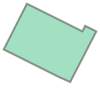

In [68]:
overlapping.iloc[0].geometry

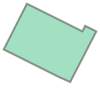

In [69]:
overlapping.iloc[1].geometry

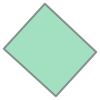

In [71]:
overlapping.iloc[2].geometry

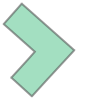

In [70]:
overlapping.iloc[3].geometry